In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [2]:
LR = 5e-5
BATCH_SIZE = 32
IMG_SIZE = 64
IMG_CHANNELS = 3
LATENT_DIM = 100
EPOCHS = 40
DISC_FEATURES = 64
GEN_FEATURES = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


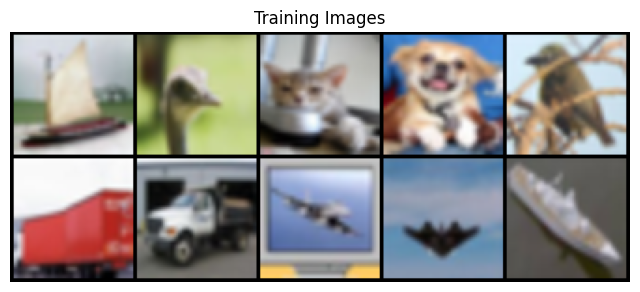

In [3]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Results/WGANGP_RealImg.jpg', format='jpeg', dpi=100, bbox_inches='tight')

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, disc_features):
        super(Discriminator, self).__init__()
        self.disc_net = nn.Sequential(
            nn.Conv2d(img_channels, disc_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.disc_block(disc_features, disc_features * 2, 4, 2, 1),
            self.disc_block(disc_features * 2, disc_features * 4, 4, 2, 1),
            self.disc_block(disc_features * 4, disc_features * 8, 4, 2, 1),
            nn.Conv2d(disc_features * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc_net(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, gen_features):
        super(Generator, self).__init__()
        self.gen_net = nn.Sequential(
            self.gen_block(latent_dim, gen_features * 8, 4, 1, 0),
            self.gen_block(gen_features * 8, gen_features * 4, 4, 2, 1),
            self.gen_block(gen_features * 4, gen_features * 2, 4, 2, 1),
            self.gen_block(gen_features * 2, gen_features, 4, 2, 1),
            nn.ConvTranspose2d(gen_features, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen_net(x)

In [5]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake):
    batch_size, c, h, w = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated)
    gradient = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty

In [6]:
if not os.path.exists('Models'):
    os.makedirs('Models')

def save_model(model, name):
    if name == 'generator':
        print("=> Saving Generator model!")
        torch.save(model, "Models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif name == 'discriminator':
        print("=> Saving Discriminator model!")
        torch.save(model, "Models/CIFAR_wganGP_DISCRIMINATOR.pth.tar")

def load_model(generator, discriminator):
    print("=> Loading models!")
    generator = torch.load("Models/CIFAR_wganGP_GENERATOR.pth.tar")
    discriminator = torch.load("Models/CIFAR_wganGP_DISCRIMINATOR.pth.tar")
    return generator, discriminator

In [ ]:
generator = Generator(LATENT_DIM, IMG_CHANNELS, GEN_FEATURES).to(device)
discriminator = Discriminator(IMG_CHANNELS, DISC_FEATURES).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

optimizer_G = optim.RMSprop(generator.parameters(), lr=LR)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=LR)

fixed_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)

generator.train()
discriminator.train()

# Training loop
gen_losses = []
disc_losses = []
disc_losses_penalty = []
generated_images = []
fid_scores = []
iterations = 0

print("Traning")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch += 1
    for batch_idx, data in enumerate(data_loader, 0):
        real_images = data[0].to(device)
        batch_size = real_images.shape[0]

        # Train Discriminator
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
            fake_images = generator(noise)
            critic_real = discriminator(real_images).reshape(-1)
            critic_fake = discriminator(fake_images).reshape(-1)
            gp = gradient_penalty(discriminator, real_images, fake_images)
            disc_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            discriminator.zero_grad()
            disc_loss.backward(retain_graph=True)
            optimizer_D.step()

        # Train Generator
        output = discriminator(fake_images).reshape(-1)
        gen_loss = -torch.mean(output)
        generator.zero_grad()
        gen_loss.backward()
        optimizer_G.step()

        gen_losses.append(gen_loss.detach().cpu())
        disc_losses.append(disc_loss.detach().cpu())
        disc_losses_penalty.append(gp.detach().cpu())

        if (iterations % 500 == 0) or ((epoch == EPOCHS) and (batch_idx == len(data_loader) - 1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                generated_images.append(utils.make_grid(fake, padding=2, normalize=True))

        iterations += 1

        # Calculate FID
        fid = calculate_fid(real_images, fake_images, inception_model)
        fid_scores.append(fid)

        print(f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(data_loader)} "
              f"Discriminator Loss: {disc_loss:.3f}, Generator Loss: {gen_loss:.3f}, FID Score: {fid:.3f}",
              end="\r", flush=True)

    # Save generated images
    labels = torch.arange(0, 10, dtype=torch.long, device=device)
    noise = torch.randn(10, 100, device=device)
    images = generator(fixed_noise)
    if not os.path.exists('Results/WGANGP_FAKE'):
        os.makedirs('Results/WGANGP_FAKE')
    if not os.path.exists('Results/WGANGP_REAL'):
        os.makedirs('Results/WGANGP_REAL')
    utils.save_image(images.detach(), f'Results/WGANGP_FAKE/WGANGP_epoch_{epoch:03d}.png', normalize=True)
    utils.save_image(real_images.detach(), f'Results/WGANGP_REAL/WGANGP_epoch_{epoch:03d}.png', normalize=True)

end_time = time.time()
print(f'\n\nElapsed time: {end_time - start_time:.2f} seconds.')

save_model(generator, 'generator')
save_model(discriminator, 'discriminator')

if not os.path.exists('Results/Loss_Data'):
    os.makedirs('Results/Loss_Data')

np.save('Results/Loss_Data/WGANGP_GLoss', gen_losses)
np.save('Results/Loss_Data/WGANGP_DLoss', disc_losses)

gen_losses = np.load('Results/Loss_Data/WGANGP_GLoss.npy')
disc_losses = np.load('Results/Loss_Data/WGANGP_DLoss.npy')

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/Loss.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

real_batch = next(iter(data_loader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))
plt.savefig('Results/WGANGP_Best_Fake_32.pdf', format='pdf', dpi=100, bbox_inches='tight